In [1]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [2]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [3]:
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

# Adjusting the labels
y_train_valid -= 769
y_test -= 769

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=42)

In [5]:
def train_data_prep(X,y,sub_sample,average,noise):
    total_X = None
    total_y = None
    X = X[:,:,0:800]
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    total_y = y
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))    
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y

In [6]:
def preprocess_data(X, y=None, sub_sample=2, average=2, noise_level=0.5, apply_noise=True):
    X = X[:,:,0:800]  # (sample, 22, 800)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    if apply_noise:
        X_max += np.random.normal(0.0, noise_level, X_max.shape)
        if y is not None:
            y = np.tile(y, sub_sample)
    return X_max, y

In [7]:
import tensorflow as tf

In [8]:
X_test_prep, _ = preprocess_data(X_test, sub_sample=2, average=2, noise_level=0.5, apply_noise=False)
y_test_prep = tf.keras.utils.to_categorical(y_test, 4)
X_test_prep = np.swapaxes(X_test_prep, 1, 2)

print('Shape of test set:', X_test_prep.shape)
print('Shape of test labels after categorical conversion:', y_test_prep.shape)

Shape of test set: (443, 400, 22)
Shape of test labels after categorical conversion: (443, 4)


In [9]:
X_train_prep, y_train_prep = train_data_prep(X_train,y_train,2,2,True)
X_valid_prep, y_valid_prep = preprocess_data(X_valid, y_valid, apply_noise=False)
y_train_prep = tf.keras.utils.to_categorical(y_train_prep, 4)
y_valid_prep = tf.keras.utils.to_categorical(y_valid_prep, 4)
X_train_prep = np.swapaxes(X_train_prep, 1, 2)
X_valid_prep = np.swapaxes(X_valid_prep, 1, 2)

print('Shape of training set:', X_train_prep.shape)
print('Shape of training labels:',y_train_prep.shape)
print('Shape of validation set:', X_valid_prep.shape)
print('Shape of validation labels:',y_valid_prep.shape)

Shape of X after subsampling and concatenating: (7612, 22, 400)
Shape of Y: (7612,)
Shape of training set: (7612, 400, 22)
Shape of training labels: (7612, 4)
Shape of validation set: (212, 400, 22)
Shape of validation labels: (212, 4)


In [10]:
import random
random.seed(12345)
np.random.seed(42)
tf.random.set_seed(1234)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, GRU, Dense, Flatten

conv_rnn_model = Sequential()

# First Conv1D layer with input shape specified
conv_rnn_model.add(Conv1D(filters=20, kernel_size=8, padding='causal', activation='relu', input_shape=(400, 22)))

# Regularization after the first Conv1D layer
conv_rnn_model.add(BatchNormalization())
conv_rnn_model.add(Dropout(0.2))

# Additional Conv1D layers with increasing dilation rates and regularization
for rate in (1, 2, 4, 8) * 2:
    conv_rnn_model.add(Conv1D(filters=20, kernel_size=8, padding='causal', activation='relu', dilation_rate=rate))
    conv_rnn_model.add(MaxPooling1D(pool_size=2))
    conv_rnn_model.add(BatchNormalization())
    conv_rnn_model.add(Dropout(0.2))

# GRU layer to capture temporal dependencies
conv_rnn_model.add(GRU(50, return_sequences=False))

# Dense layers for classification
conv_rnn_model.add(Dense(100, activation='relu'))
conv_rnn_model.add(Dense(4, activation='softmax'))  # Assuming 4 classes in your classification task

# Summary of the model
conv_rnn_model.summary()

/Users/samuelperrott/miniconda3/envs/c147/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 400, 20)        │         3,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 400, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 400, 20)        │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 200, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 200, 20)        │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 20)        │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 20)         │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 25, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 25, 20)         │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 12, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 20)         │            80 │
│ (BatchNormalization)            │                        │             

 Total params: 46,324 (180.95 KB)

 Trainable params: 45,964 (179.55 KB)

 Non-trainable params: 360 (1.41 KB)

In [12]:
learning_rate = 1e-3
epochs = 100
conv_rnn_model_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compiling the model
conv_rnn_model.compile(loss='categorical_crossentropy',
                 optimizer=conv_rnn_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
conv_rnn_model_results = conv_rnn_model.fit(X_train_prep,
             y_train_prep,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid_prep, y_valid_prep), verbose=True)

Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.2513 - loss: 1.3939 - val_accuracy: 0.2642 - val_loss: 1.3899
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.2658 - loss: 1.3875 - val_accuracy: 0.2830 - val_loss: 1.3658
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.3162 - loss: 1.3595 - val_accuracy: 0.3255 - val_loss: 1.3347
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.3559 - loss: 1.3212 - val_accuracy: 0.4104 - val_loss: 1.2908
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.4192 - loss: 1.2486 - val_accuracy: 0.3821 - val_loss: 1.3259
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4260 - loss: 1.2210 - val_accuracy: 0.4292 - val_loss: 1.2350
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.4570 - loss: 1.1818 - val_accuracy: 0.4575 - val_loss: 1.2006
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4773 - loss: 1.1457 -

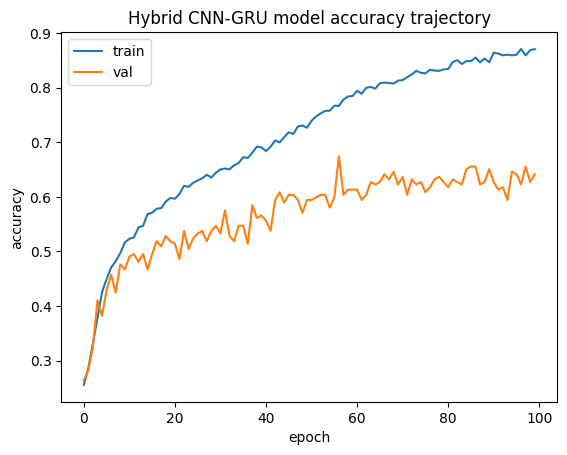

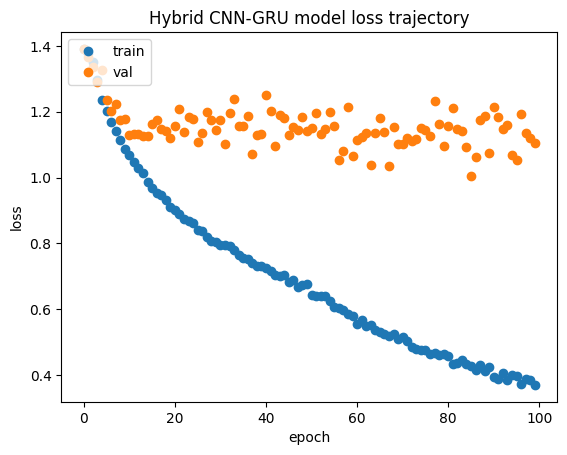

In [15]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(conv_rnn_model_results.history['accuracy'])
plt.plot(conv_rnn_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(conv_rnn_model_results.history['loss'],'o')
plt.plot(conv_rnn_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
## Testing the hybrid CNN-LSTM model

conv_rnn_model_score = conv_rnn_model.evaluate(X_test_prep, y_test_prep, verbose=0)
print('Test accuracy of the hybrid CNN-GRU model:',conv_rnn_model_score[1])

Test accuracy of the hybrid CNN-GRU model: 0.6162528395652771
